In [1]:
! pip install -q diffusers

In [2]:
# minimal diffusion model for clouds, using huggingface diffusers architecture rFor my complete from-scratch implementation, check the the tiny_diffusion folder
# implemented in pytorch
from time import time
import torchvision
import torch
from torch.nn import functional as fnn
from torch.utils.data import DataLoader
from torchvision import transforms

from datasets import load_dataset
from diffusers import DDPMPipeline
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from diffusers.models.unets import UNet2DModel
from diffusers.optimization import get_cosine_schedule_with_warmup
from huggingface_hub import notebook_login, login, get_full_repo_name, HfApi, create_repo

import numpy as np
import wandb
from PIL import Image as pillow_image
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

2024-07-05 05:11:48.297081: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-05 05:11:48.297222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-05 05:11:48.422964: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
hf_key = user_secrets.get_secret("HF_TOKEN")
wandb_key = user_secrets.get_secret("wandb_key")

# notebook_login(hf_key)

In [4]:
login(hf_key)

model_name = "sky_diffuse"
model_id = get_full_repo_name(model_name)

# create_repo(model_id)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [5]:

# geeral variables
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sky_image_data = load_dataset("tensorkelechi/sky_images", split="train")
image_size = 128
batch_size = 32

# utility functions

def display_img(img):
    img = img * 0.5 + 0.5
    imgrid = torchvision.utils.make_grid(img)
    grid = imgrid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid = pillow_image.fromarray(np.array(grid).astype(np.uint8))

    return grid


def image_grid(img_list: list, size=image_size):
    out_image = pillow_image.new("RGB", (size * len(img_list), size))
    for k, img in enumerate(img_list):
        out_image.paste(img.resize(size, size), (k * size, 0))
    return out_image


Generating train split:   0%|          | 0/4653 [00:00<?, ? examples/s]

In [6]:
image_pp = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def image_transforms(data):
    image_data = [image_pp(image.convert("RGB")) for image in data["image"]]

    return {"image": image_data}

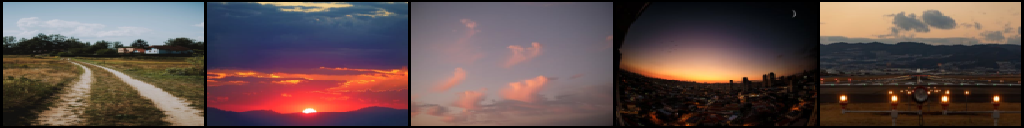

In [7]:
sky_image_data.set_transform(image_transforms)
train_dataloader = DataLoader(sky_image_data, batch_size=batch_size, shuffle=True)

# for sample display of images/shape check
sample = next(iter(train_dataloader))["image"].to(device)[:5]
display_img(sample).resize((8 * image_size, image_size), resample=pillow_image.NEAREST)

shape of noised sample=> torch.Size([5, 3, 128, 128])
shape of image sample=> torch.Size([5, 3, 128, 128])


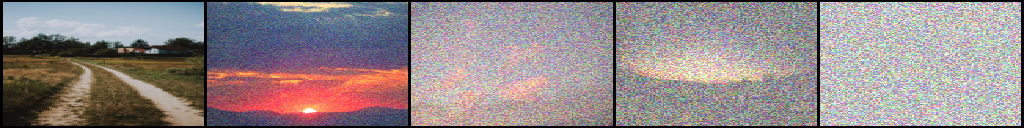

In [8]:
# scheduler for noise addition
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

noise = torch.rand_like(sample)
timesteps = torch.linspace(0, 999, 5).long().to(device)
noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
print(f"shape of noised sample=> {noisy_sample.shape}")
print(f"shape of image sample=> {sample.shape}")
display_img(noisy_sample).resize((8 * image_size, image_size), resample=pillow_image.NEAREST)

In [9]:
# define the unet model for downsampleing and upsampling
unet_model = UNet2DModel(
    sample_size=image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 128, 256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
)

unet_model.to(device)

UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(64, 64, ker

In [10]:
unet_model.to(device)

with torch.no_grad():
    pred = unet_model(noisy_sample, timesteps).sample

print(pred.shape)
# print(pred)

torch.Size([5, 3, 128, 128])


In [11]:
label = "wandb_key"
wandb_key = UserSecretsClient().get_secret(label)

In [12]:
optimizer = torch.optim.AdamW(unet_model.parameters(), lr=4e-4)

losses = []
epochs = 50
wandb.login(key=wandb_key)
wandb.init(project="tiny_diffuse", name="minidiffuse_sky2_M")
# lr_scheduler = get_cosine_schedule_with_warmup()

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tensorkelechi (tensor_airl). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240705_051208-iw7c0qvn
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run minidiffuse_sky2_M
wandb: ⭐️ View project at https://wandb.ai/tensor_airl/tiny_diffuse
wandb: 🚀 View run at https://wandb.ai/tensor_airl/tiny_diffuse/runs/iw7c0qvn


In [13]:
# training loop
for epoch in tqdm(range(epochs)):
    print(f"training epoch @ {epoch + 1}")
    for step, batch in tqdm(enumerate(train_dataloader)):
        images = batch["image"].to(device)
        noise = torch.randn(images.shape).to(device)  # noise to add to the images
        b = images.shape[0]

        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (b,), device=images.device
        ).long()  # random timestep
        noisy_images = noise_scheduler.add_noise(
            images, noise, timesteps
        )  # add noise to images
        noise_pred = unet_model(noisy_images, timesteps, return_dict=False)[
            0
        ]  # model prediction

        # loss function
        loss = fnn.mse_loss(noise_pred, noise)
        loss.backward()
        losses.append(loss.item())
        wandb.log({"loss": loss})

        # gradient update
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"epoch @ {epoch + 1} => loss: {epoch_loss}")
    print('_____________________________')

  0%|          | 0/50 [00:00<?, ?it/s]

training epoch @ 1


0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch @ 1 => loss: 0.10444209390409188
_____________________________
training epoch @ 2


0it [00:00, ?it/s]

epoch @ 2 => loss: 0.049645425598711185
_____________________________
training epoch @ 3


0it [00:00, ?it/s]

epoch @ 3 => loss: 0.041171954829909214
_____________________________
training epoch @ 4


0it [00:00, ?it/s]

epoch @ 4 => loss: 0.03752006256110864
_____________________________
training epoch @ 5


0it [00:00, ?it/s]

epoch @ 5 => loss: 0.03533603370904106
_____________________________
training epoch @ 6


0it [00:00, ?it/s]

epoch @ 6 => loss: 0.032647730157493726
_____________________________
training epoch @ 7


0it [00:00, ?it/s]

epoch @ 7 => loss: 0.03414157616000061
_____________________________
training epoch @ 8


0it [00:00, ?it/s]

epoch @ 8 => loss: 0.03384242154504746
_____________________________
training epoch @ 9


0it [00:00, ?it/s]

epoch @ 9 => loss: 0.031769183234707135
_____________________________
training epoch @ 10


0it [00:00, ?it/s]

epoch @ 10 => loss: 0.03187865642065259
_____________________________
training epoch @ 11


0it [00:00, ?it/s]

epoch @ 11 => loss: 0.030269983613684978
_____________________________
training epoch @ 12


0it [00:00, ?it/s]

epoch @ 12 => loss: 0.031484645446890024
_____________________________
training epoch @ 13


0it [00:00, ?it/s]

epoch @ 13 => loss: 0.030585603546096036
_____________________________
training epoch @ 14


0it [00:00, ?it/s]

epoch @ 14 => loss: 0.03125950597124557
_____________________________
training epoch @ 15


0it [00:00, ?it/s]

epoch @ 15 => loss: 0.029935051833776986
_____________________________
training epoch @ 16


0it [00:00, ?it/s]

epoch @ 16 => loss: 0.028000654512378452
_____________________________
training epoch @ 17


0it [00:00, ?it/s]

epoch @ 17 => loss: 0.03034152899396746
_____________________________
training epoch @ 18


0it [00:00, ?it/s]

epoch @ 18 => loss: 0.026636906829343675
_____________________________
training epoch @ 19


0it [00:00, ?it/s]

epoch @ 19 => loss: 0.028895071203731103
_____________________________
training epoch @ 20


0it [00:00, ?it/s]

epoch @ 20 => loss: 0.029812481420191182
_____________________________
training epoch @ 21


0it [00:00, ?it/s]

epoch @ 21 => loss: 0.03075695809053436
_____________________________
training epoch @ 22


0it [00:00, ?it/s]

epoch @ 22 => loss: 0.0279366412416917
_____________________________
training epoch @ 23


0it [00:00, ?it/s]

epoch @ 23 => loss: 0.028841420134197767
_____________________________
training epoch @ 24


0it [00:00, ?it/s]

epoch @ 24 => loss: 0.028617778553767768
_____________________________
training epoch @ 25


0it [00:00, ?it/s]

epoch @ 25 => loss: 0.027383664724965617
_____________________________
training epoch @ 26


0it [00:00, ?it/s]

epoch @ 26 => loss: 0.02697445253190929
_____________________________
training epoch @ 27


0it [00:00, ?it/s]

epoch @ 27 => loss: 0.02772052089798532
_____________________________
training epoch @ 28


0it [00:00, ?it/s]

epoch @ 28 => loss: 0.027150824921180126
_____________________________
training epoch @ 29


0it [00:00, ?it/s]

epoch @ 29 => loss: 0.028067089999987655
_____________________________
training epoch @ 30


0it [00:00, ?it/s]

epoch @ 30 => loss: 0.02751235219917885
_____________________________
training epoch @ 31


0it [00:00, ?it/s]

epoch @ 31 => loss: 0.02736799469957613
_____________________________
training epoch @ 32


0it [00:00, ?it/s]

epoch @ 32 => loss: 0.027840133329011398
_____________________________
training epoch @ 33


0it [00:00, ?it/s]

epoch @ 33 => loss: 0.02904759632576614
_____________________________
training epoch @ 34


0it [00:00, ?it/s]

epoch @ 34 => loss: 0.02577546421336393
_____________________________
training epoch @ 35


0it [00:00, ?it/s]

epoch @ 35 => loss: 0.026188268575000846
_____________________________
training epoch @ 36


0it [00:00, ?it/s]

epoch @ 36 => loss: 0.028205602704100823
_____________________________
training epoch @ 37


0it [00:00, ?it/s]

epoch @ 37 => loss: 0.02541626553523214
_____________________________
training epoch @ 38


0it [00:00, ?it/s]

epoch @ 38 => loss: 0.02768094066453919
_____________________________
training epoch @ 39


0it [00:00, ?it/s]

epoch @ 39 => loss: 0.027246385793622634
_____________________________
training epoch @ 40


0it [00:00, ?it/s]

epoch @ 40 => loss: 0.027269670988547885
_____________________________
training epoch @ 41


0it [00:00, ?it/s]

epoch @ 41 => loss: 0.02642492368204953
_____________________________
training epoch @ 42


0it [00:00, ?it/s]

epoch @ 42 => loss: 0.027471632798750922
_____________________________
training epoch @ 43


0it [00:00, ?it/s]

epoch @ 43 => loss: 0.025928017855558084
_____________________________
training epoch @ 44


0it [00:00, ?it/s]

epoch @ 44 => loss: 0.025917010994194304
_____________________________
training epoch @ 45


0it [00:00, ?it/s]

epoch @ 45 => loss: 0.026785406571085732
_____________________________
training epoch @ 46


0it [00:00, ?it/s]

epoch @ 46 => loss: 0.02621637286031491
_____________________________
training epoch @ 47


0it [00:00, ?it/s]

epoch @ 47 => loss: 0.026699679788865456
_____________________________
training epoch @ 48


0it [00:00, ?it/s]

epoch @ 48 => loss: 0.02554429777936168
_____________________________
training epoch @ 49


0it [00:00, ?it/s]

epoch @ 49 => loss: 0.027318687235604818
_____________________________
training epoch @ 50


0it [00:00, ?it/s]

epoch @ 50 => loss: 0.02763130074392443
_____________________________


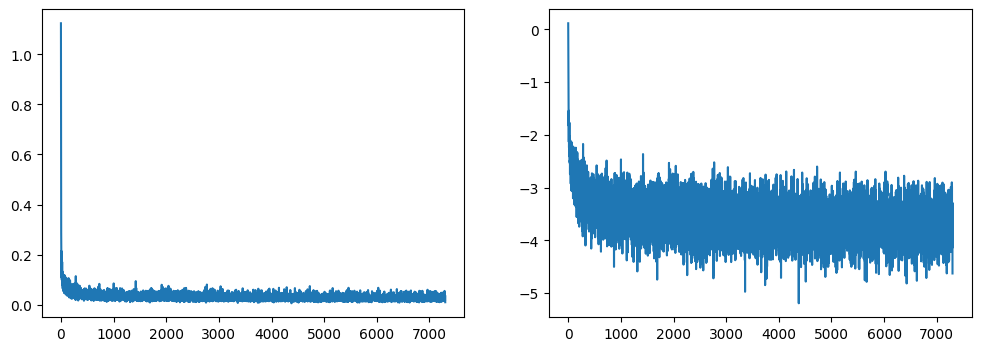

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

0it [00:00, ?it/s]

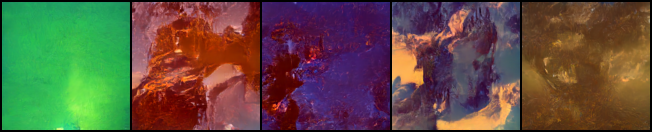

In [15]:
try:
    torch.save(unet_model.state_dict(), "mini_diffuse.pt")
except Exception as e:
    print(f"error saving model {e}")

# sample generation
rd_sample = torch.randn(4, 3, image_size, image_size)

for k, c in tqdm(enumerate(noise_scheduler.timesteps)):
    with torch.no_grad():
        residual = unet_model(sample, c).sample  # model prediction

    sample = noise_scheduler.step(residual, c, sample).prev_sample

display_img(sample)

In [16]:
# model pipeline for aving and upload
sky_diffuse_pipe = DDPMPipeline(unet=unet_model, scheduler=noise_scheduler)
sky_diffuse_pipe.save_pretrained("sky_diff")


# push model to hub
sky_diffuse_pipe.push_to_hub('tensorkelechi/sky_diffuse')

README.md:   0%|          | 0.00/389 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/74.2M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/tensorkelechi/sky_diffuse/commit/4480cdfbf1a806f35302e77331c10259e7ef726e', commit_message='Upload DDPMPipeline', commit_description='', oid='4480cdfbf1a806f35302e77331c10259e7ef726e', pr_url=None, pr_revision=None, pr_num=None)

In [17]:
hf_api = HfApi()

hf_api.upload_folder(
    folder_path="sky_diff/scheduler", path_in_repo="", repo_id=model_id
)
hf_api.upload_folder(folder_path="sky_diff/unet", path_in_repo="", repo_id=model_id)
hf_api.upload_file(
    path_or_fileobj="sky_diff/model_index.json",
    path_in_repo="model_index.json",
    repo_id=model_id,
)

CommitInfo(commit_url='https://huggingface.co/tensorkelechi/sky_diffuse/commit/7f6c8b86ed90a45d870b75db4a1f7c92c5129327', commit_message='Upload model_index.json with huggingface_hub', commit_description='', oid='7f6c8b86ed90a45d870b75db4a1f7c92c5129327', pr_url=None, pr_revision=None, pr_num=None)

In [18]:
# # readme

# content = f"""
# ---
# license: apache-2.0
# tags:
# - pytorch
# - diffusers
# - unconditional-image-generation
# - diffusion-models-class
# ---

# This model is a diffusion model for unconditional image generation of clouds, skies, etc

# ## Usage

# ```python
# from diffusers import DDPMPipeline

# pipeline = DDPMPipeline.from_pretrained('{model_id}')
# image = pipeline().images[0]
# image
# """

In [19]:
# from huggingface_hub import ModelCard

# card = ModelCard(content)
# card.push_to_hub(model_id)

model_index.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

unet/config.json:   0%|          | 0.00/962 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/74.2M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

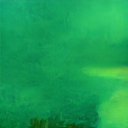

In [20]:
pipeline = DDPMPipeline.from_pretrained('tensorkelechi/sky_diffuse').to(device)
image = pipeline().images[0]
image.save("image.png")
image

  0%|          | 0/1000 [00:00<?, ?it/s]

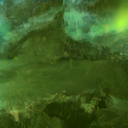

In [21]:
image2 = pipeline().images[0]

image2.save("image2.png")
image2

In [22]:
print('complete')

complete
